<a href="https://colab.research.google.com/github/xpdlaldam/nlp/blob/master/HF_audio_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.

In [ ]:
"""
1. Background
By nature, a sound wave is a continuous signal, meaning it contains an infinite number of signal values in a given time.
This poses problems for digital devices which expect finite arrays.
To be processed, stored, and transmitted by digital devices, the continuous sound wave needs to be converted into a series of discrete values,
known as a digital representation.

x. Frequency
  - How many times a sound wave oscillates (vibrates) per second. It determines the pitch of a sound. Unit is Hz
  - High frequency vs low frequency:
    - high frequency sounds have shorter wavelenghts, often a high pitch sound (treble, sharp sound)
    - low frequency sounds have longer wavelenghts, often a low pitch sound (bass, flat sound)

2. Sampling and sampling rate
  2-1. Sampling:
    - the process of measuring the value of a continuous signal at fixed time steps. The sampled waveform is discrete, since it contains a finite number of signal values at uniform intervals.

  2-2. Sampling rate (also called sampling frequency) *
    - the number of samples taken in "one second" and is measured in hertz (Hz)
    - how often the samples are taken

3. Resampling
  - Since sequences are different for audio examples at different sampling rates, it will be challenging for models to generalize between different sampling rates. So "resampling" is the process of making the sampling rates match, and is part of preprocessing the audio data.

4. Amplitude and bit depth
  4-1. Amplitude:
    - Sound is made by "changes in air pressure" at frequencies that are audible to humans. The amplitude of a sound describes the sound pressure level at any given instant and is measured in decibels (dB). We perceive the amplitude as loudness

  4-2. bit depth:
    - In digital audio, each audio sample records the amplitude of the audio wave at a point in time. The bit depth of the sample determines how much "precision" this amplitude value can be described. The higher the bit depth, the more faithfully the digital representation approximates the original continuous sound wave

    - The most common audio bit depths are 16-bit and 24-bit. Each is a binary term, representing the number of possible steps to which the amplitude value can be quantized when it’s converted from continuous to discrete: 65,536 steps for 16-bit audio, a whopping 16,777,216 steps for 24-bit audio. Because quantizing involves rounding off the continuous value to a discrete value, the sampling process introduces noise. The higher the bit depth, the smaller this quantization noise. In practice, the quantization noise of 16-bit audio is already small enough to be inaudible, and using higher bit depths is generally not necessary

    - You may also come across 32-bit audio. This stores the samples as floating-point values, whereas 16-bit and 24-bit audio use integer samples. The precision of a 32-bit floating-point value is 24 bits, giving it the same bit depth as 24-bit audio. Floating-point audio samples are expected to lie within the [-1.0, 1.0] range. Since machine learning models naturally work on floating-point data, the audio must first be converted into floating-point format before it can be used to train the model.
"""

In [ ]:
import librosa
array, sampling_rate = librosa.load(librosa.ex("trumpet"))

In [ ]:
array

In [ ]:
sampling_rate

# 2. Visualize audio

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

## 2-1. Waveform

In [ ]:
"""
y-axis: amplitude
x-axis: time
In other words, each x-axis point corresponds to a single sample value that was taken when this sound was sampled.
"""
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

## 2-2. Frequency Spectrum

In [ ]:
"""
Describes the individual frequencies that make up the signal and how strong they are.

Visualizes the amplitudes of the individual frequencies at a fixed point in time.

Amplitude (dB) vs Frequency (Hz) graph

Tip: While it is possible to plot the spectrum of the entire sound, it’s more useful to look at a small region instead. Here we’ll take the DFT over the first 4096 samples, which is roughly the length of the first note being played
"""

In [ ]:
import numpy as np

dft_input = array[:4096]

# calculate the discrete Fourier transform (DFT)
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

## 2-3. Spectogram

In [ ]:
"""
The problem of spectrums is that it only shows a partial snapshot of the frequencies at a given instant => solution: take multiple DFTs each covering only a small slice of time and stack the resulting spectra (plural of specturm) together into a spectrogram

A spectogram plots the frequency content of an audio signal as it changes over time. It allows you to see
  - time
  - frequency
  - amplitude
all in one graph. The algorithm behind this computation is called STFT or Short Time Fourier Transform

Each vertical slice in a spectogram corresponds to a single frequency spectrum. By default, librosa.stft() splits the audio signal into segments of 2048 samples, which gives a good trade-off between frequency resolution and time resolution

Since the spectrogram and the waveform are different views of the same data, it’s possible to turn the spectrogram back into the original waveform using the inverse STFT. However, this requires the phase information in addition to the amplitude information. If the spectrogram was generated by a machine learning model, it typically only outputs the amplitudes. In that case, we can use a phase reconstruction algorithm such as the classic Griffin-Lim algorithm, or using a neural network called a vocoder, to reconstruct a waveform from the spectrogram.

Spectrograms aren’t just used for visualization. Many machine learning models will take spectrograms as input — as opposed to waveforms — and produce spectrograms as output.

Now that we know what a spectrogram is and how it’s made, let’s take a look at a variant of it widely used for speech processing: the mel spectrogram
"""

In [ ]:
import numpy as np

D = librosa.stft(array, n_fft=2048) # default
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

In [ ]:
D = librosa.stft(array, n_fft=4096) # a higher value returns a more detailed frequency but lower time resolution and slower computation
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

## 2-4. Mel Spectogram

In [ ]:
"""
In a standard spectrogram, the frequency axis is linear and is measured in hertz (Hz). However, the human auditory system is more sensitive to changes in lower frequencies than higher frequencies, and this sensitivity decreases logarithmically as frequency increases. The mel scale is a perceptual scale that approximates the non-linear frequency response of the human ear
"""

In [ ]:
"""
n_mels stands for the number of mel bands to generate. The mel bands define a set of frequency ranges that divide the spectrum into perceptually meaningful components, using a set of filters whose shape and spacing are chosen to mimic the way the human ear responds to different frequencies. Common values for n_mels are 40 or 80. fmax indicates the highest frequency (in Hz) we care about

Not all mel spectrograms are the same! There are two different mel scales in common use ("htk" and "slaney"), and instead of the power spectrogram the amplitude spectrogram may be used. HTK and Slaney are two different formulas for converting between Hz (regular frequency) and mel (perceptual frequency)

Caution: Creating a mel spectrogram is a lossy operation as it involves filtering the signal. Converting a mel spectrogram back into a waveform is more difficult than doing this for a regular spectrogram, as it requires estimating the frequencies that were thrown away. This is why machine learning models such as HiFiGAN vocoder are needed to produce a waveform from a mel spectrogram.

Compared to a standard spectrogram, a mel spectrogram can capture more meaningful features of the audio signal for human perception, making it a popular choice in tasks such as speech recognition, speaker identification, and music genre classification.
"""

S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=80, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max) # need power to dB instead of amplitude to dB as the above melspectrogram creates a power spectrogram

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

# 3. Explore Datasets Library

In [ ]:
!pip install soundfile librosa datasets[audio] torchcodec

In [ ]:
# restart session

In [ ]:
# Get all available language configurations
from datasets import get_dataset_config_names
configs = get_dataset_config_names("PolyAI/minds14")
configs

In [ ]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds # num_rows: 654 = number of audio files

In [ ]:
minds.column_names

In [ ]:
# check original sampling rate: sampling_rate=8000
minds.features['audio']

In [ ]:
minds[0]

# 4. Preprocessing an audio dataset

## 4-1. Resampling

In [ ]:
# Upsampling: change the sampling rate from 8kHz to 16kHz
from datasets import Audio
minds_resampled = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds_resampled.features['audio'] # sampling_rate is now 16_000

## 4-2. Filtering

In [ ]:
"""
You may need to filter the data based on some criteria. One of the common cases involves limiting the audio examples to a certain duration. For instance, we might want to filter out any examples longer than 20s to prevent out-of-memory errors when training a model.
"""

In [ ]:
# access array
minds_resampled[0]['audio']['array']

In [ ]:
len(minds_resampled[0]['audio']['array'])

In [ ]:
len(minds_resampled[1]['audio']['array'])

In [ ]:
len(minds_resampled[0]['audio']['array']) / minds_resampled[0]['audio']['sampling_rate'] # duration in seconds for the first audio file
# ex) 16_000 samples: 1 second = 124_830 samples : x second => x = 7.8 seconds

In [ ]:
minds_resampled[0]['audio']['sampling_rate']

In [ ]:
import librosa

In [ ]:
len(minds_resampled)

In [ ]:
# use librosa to get the audio's duration from the audio file
new_column = [
    librosa.get_duration(y=x["array"], sr=x["sampling_rate"]) for x in minds_resampled["audio"]
]
new_column

In [ ]:
new_column[0] # duration in seconds of the first audio file

In [ ]:
len(new_column)

In [ ]:
MAX_DURATION_IN_SECONDS = 20.0
def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [ ]:
minds_resampled = minds_resampled.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds_resampled = minds_resampled.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds_resampled = minds_resampled.remove_columns(["duration"])
minds_resampled # reduced from 654 to 624 audio files (removed files exceeding 20 seconds)

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 624
})

In [ ]:
minds_resampled.features['audio'] # check upsampled sampling_rate

Audio(sampling_rate=16000, decode=True, stream_index=None)

## 4-3. Adjust to Model Input using pre-trained Whisper model

In [ ]:
import librosa

In [ ]:
"""
For every supported audio model, 🤗 Transformers offer a "feature extractor" class that can convert raw audio data into the input features the model expects

How the Whisper feature extractor works:
  First, the Whisper feature extractor pads/truncates a batch of audio examples such that all examples have an input length of 30s. Since all elements in the batch are padded/truncated to a maximum length in the input space, there is no need for an attention mask. Hence Whisper is trained to operate without an attention mask and infer directly from the speech signals where to ignore the inputs

  The second operation that the Whisper feature extractor performs is converting the padded audio arrays to log-mel spectrograms
"""

In [ ]:
from transformers import WhisperFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

preprocessor_config.json: 0.00B [00:00, ?B/s]

In [ ]:
def prepare_dataset(example):
    audio = example["audio"]

    if audio["sampling_rate"] != 16000:
        audio_array = librosa.resample(
            audio["array"], orig_sr=audio["sampling_rate"], target_sr=16000
        )
        audio = {"array": audio_array, "sampling_rate": 16000}

    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [ ]:
minds_resampled_whisper = minds_resampled.map(prepare_dataset)
minds_resampled_whisper

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 624
})

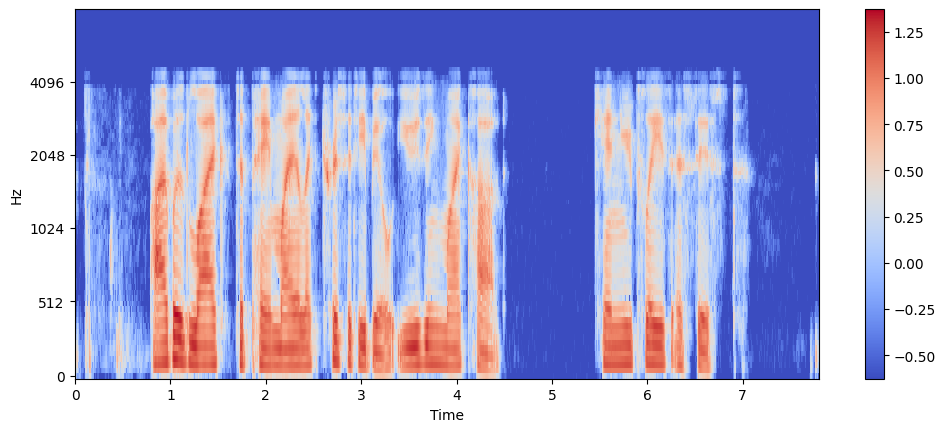

In [ ]:
## plot mel spectogram of first audio file
import numpy as np
import matplotlib.pyplot as plt

example = minds_resampled_whisper[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

In [ ]:
"""
Interpret the above audio frequency distribution:
  - Low Frequencies (0-512 Hz):
  Strong energy (red/orange) in the lower frequencies
  This is typical for human speech - contains the fundamental frequency of the voice
  Indicates a male voice or low-pitched female voice (most energy concentrated here)

  - Mid Frequencies (512-2048 Hz):
  Moderate energy (light blue/orange)
  Contains vowel formants and voice harmonics
  Critical for speech intelligibility

  - High Frequencies (2048-4096 Hz):
  Less energy (mostly blue)
  Contains consonants and fricatives (s, sh, f sounds)
  Some vertical stripes suggest consonant sounds
"""

In [ ]:
minds_resampled_whisper[0]['audio']

In [ ]:
from IPython.display import Audio

audio = minds_resampled_whisper[0]['audio']
Audio(audio['array'], rate=audio['sampling_rate'])

# Applications

## 1. Explore Speechbrain's Accent Classification Model using Local .wmf Irish English files

In [ ]:
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

In [ ]:
import speechbrain as sb

In [ ]:
import torchaudio
from speechbrain.inference import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="Jzuluaga/accent-id-commonaccent_ecapa", savedir="pretrained_models/accent-id-commonaccent_ecapa")

# print(text_lab)

In [ ]:
from scipy.io import wavfile
from google.colab import drive
import os

drive.mount('/content/drive')

In [ ]:
os.chdir("drive/MyDrive/Colab Notebooks/Data/Audio")

In [ ]:
curr_dir_files = os.listdir()
curr_dir_files[0]

In [ ]:
# Read the WAV file
sample_rate, data = wavfile.read(curr_dir_files[0])

print(f"Sample rate: {sample_rate} Hz")
print(f"Data shape: {data.shape}")

In [ ]:
from IPython.display import Audio
import numpy as np

# Play the audio sample
Audio(data, rate=sample_rate)

In [ ]:
# Irish Example
out_prob, score, index, text_lab = classifier.classify_file(curr_dir_files[0])

In [ ]:
text_lab

In [ ]:
index

## 2. Challenge

In [ ]:
"""
task1: compare the Irish a sound vs American a and plot
"""